#Importing required libraries

In [1]:
import os
import cv2
import math
import random 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
from collections import deque


from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import * 
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

#<b>Step : 1 Downloading the data and Visualizing it with labels</b>

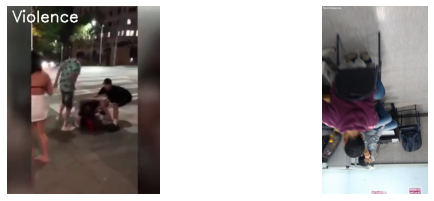

In [3]:
#walking through the directory and plotting the data 
plt.figure(figsize = (20,20))
all_classes_names = os.listdir('Real Life Violence Dataset/')
random_range = random.sample(range(len(all_classes_names)) ,2)
for counter , random_index in enumerate(random_range, 1):
  selected_class_Name = all_classes_names[random_index]
  video_files_names_list = os.listdir(f"Real Life Violence Dataset/{selected_class_Name}")
  selected_video_file_name = random.choice(video_files_names_list)
  video_reader = cv2.VideoCapture(f"Real Life Violence Dataset/{selected_class_Name}/{selected_video_file_name}")
  _, bgr_frame = video_reader.read()
  video_reader.release()
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame , selected_class_Name, (10,30) , cv2.FONT_HERSHEY_SIMPLEX , 1, (255,255,255) , 2)
  plt.subplot(5, 4 , counter)
  plt.imshow(rgb_frame)
  plt.axis('off')

#<b>Step : 2 Preprocessing the data </b>

In [4]:
IMAGE_WIDTH , IMAGE_HEIGHT = 64 , 64
SEQUENCE_LENGTH = 20 
DATASET_DIR = 'Real Life Violence Dataset'
CLASSES_LIST = ["NonViolence", "Violence"]

#Creating a function to extract , resize and Normalize Frame

In [5]:
def frame_extraction(video_path):
  frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frame_window = max(int(video_frames_count/SEQUENCE_LENGTH) ,1)
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter  * skip_frame_window)
    success , frame = video_reader.read()
    if not success :
      break
    resized_frame = cv2.resize(frame , (IMAGE_HEIGHT , IMAGE_WIDTH))
    normalized_frame= resized_frame / 255
    frames_list.append(normalized_frame)
  video_reader.release()
  return frames_list

In [6]:

def create_dataset ():
  feature = []
  labels =[]
  video_files_paths = []

  for class_index, class_name in enumerate(CLASSES_LIST):
    print(f'Extracting the video : {class_name}')
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR , class_name , file_name)
      frames = frame_extraction(video_file_path)
      if len(frames) == SEQUENCE_LENGTH:
        feature.append(frames)
        labels.append(class_index)
        video_files_paths.append(file_name)

  feature = np.asarray(feature)
  labels = np.array(labels)
  return feature , labels , video_file_path

In [7]:
feature , labels , video_file_path = create_dataset()

Extracting the video : NonViolence
Extracting the video : Violence


In [8]:
labels

array([0, 0, 0, ..., 1, 1, 1])

In [9]:
one_hot_encoded_labels = to_categorical(labels)

In [10]:
features_train , features_test , labels_train , labels_test = train_test_split(feature, one_hot_encoded_labels , test_size = 0.25 ,shuffle = True ,random_state= seed_constant  )

In [11]:
labels_train

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [12]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2( include_top=False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False

#mobilenet.summary()

9420800/9406464 [==============================] - 7s 1us/step


In [13]:
from tensorflow.keras.layers import *
def create_conv_lstm_model():
    model = Sequential()

    ########################################################################################################################
    
    #Specifying Input to match features shape
    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(mobilenet))
    
    model.add(Dropout(0.25))
                                    
    model.add(TimeDistributed(Flatten()))

    
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)  

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    
    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))
    
    
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
 
    ########################################################################################################################
 
    model.summary()
    
    return model

In [14]:
model = create_conv_lstm_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 2, 2, 1280)   2257984   
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 20, 2, 2, 1280)    0         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 5120)         0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               1319168   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [15]:

# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)
 
# Compiling the model 
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Fitting the model 
MobBiLSTM_model_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

# early_stopping_callback = EarlyStopping(monitor ='val_loss' , patience = 10 , mode = 'min' , restore_best_weights=True)

# convlstm_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), optimizer = 'Adam' , metrics = ["accuracy"])
# convlstm_model.fit(x = features_train, y= labels_train , epochs = 50 , batch_size = 4 ,
#                                                      shuffle  = True , validation_split = 0.2)

Epoch 1/50
150/150 [==============================] - 118s 732ms/step - loss: 0.6753 - accuracy: 0.5908 - val_loss: 0.7197 - val_accuracy: 0.5967 - lr: 0.0010
Epoch 2/50
150/150 [==============================] - 109s 730ms/step - loss: 0.5341 - accuracy: 0.7533 - val_loss: 0.6564 - val_accuracy: 0.6567 - lr: 0.0010
Epoch 3/50
150/150 [==============================] - 108s 720ms/step - loss: 0.4347 - accuracy: 0.8358 - val_loss: 0.4514 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/50
150/150 [==============================] - 110s 732ms/step - loss: 0.4151 - accuracy: 0.8342 - val_loss: 0.4028 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 5/50
150/150 [==============================] - 111s 744ms/step - loss: 0.3583 - accuracy: 0.8650 - val_loss: 0.3790 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 6/50
150/150 [==============================] - 112s 748ms/step - loss: 0.3157 - accuracy: 0.8800 - val_loss: 0.5460 - val_accuracy: 0.7533 - lr: 0.0010
Epoch 7/50
150/150 [==========================

#saving the model

In [16]:
model.save("model3.h5")

In [37]:
test = frame_extraction('SCVD/videos/NonViolence/nv102.mov')
test_feature = []
if len(test) == SEQUENCE_LENGTH:
  test_feature.append(test)
test_features = np.asarray(test_feature)
result  = model.predict(test_features)
print(result) 

1/1 [==============================] - 0s 124ms/step
[[9.9934441e-01 3.0047321e-04 3.5510643e-04]]
